<a href="https://colab.research.google.com/github/karencfisher/Hotel-Cancellations/blob/master/notebooks/Hotel_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders
!wget https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py

     |████████████████████████████████| 81kB 2.1MB/s 
--2020-06-15 07:21:39--  https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/tools.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8853 (8.6K) [text/plain]
Saving to: ‘tools.py’

tools.py            100%[===================>]   8.65K  --.-KB/s    in 0s      

2020-06-15 07:21:40 (53.4 MB/s) - ‘tools.py’ saved [8853/8853]



## Model implementing an artificial neural network.

This was really an aside: I was also following a Tensorflow tutorial and chose to use the hotel data set. Here I am still predicting multiple classes: no-shows as distinct from cancellations (ultimately I combined them). There is some exploration in adjusting class balances to have a similar distribution of prediction to the actual classes in the test set.

In [ ]:
import tools
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

### Load the data set and separate training, validation, and test sets.

In [ ]:
url = 'https://raw.githubusercontent.com/karencfisher/Hotel-Cancellations/master/hotel_bookings.csv'
df = pd.read_csv(url)

# Correct some target values -- should be 'no-show' or 'cancellation' when checkout and
# arrival dates same indicating no stay
df = tools.fixTarget(df)

# Prepare training, validation, and test sets
X = df.drop('reservation_status', axis=1)
y = df['reservation_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42,
                                                    stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.3,
                                                  random_state=42, stratify=y_train)

In [ ]:
X_train.head()

,hotel,is_canceled,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,arrival_date
50429,City Hotel,1,79,18,2,1,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9.0,NaN,0,Transient,126.90,0,0,2016-03-17,2016-04-30
48610,City Hotel,1,161,13,1,2,2,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,B,B,0,Non Refund,12.0,NaN,101,Transient,130.00,0,0,2016-02-10,2016-03-25
74119,City Hotel,1,335,38,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1.0,NaN,0,Contract,62.00,0,0,2015-01-01,2015-09-17
75388,City Hotel,1,323,36,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1.0,NaN,0,Transient-Party,62.00,0,0,2015-07-02,2015-09-05
98175,City Hotel,0,41,39,1,3,2,0.0,0,BB,FRA,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,NaN,NaN,0,Transient,118.96,0,2,2016-09-26,2016-09-22


### Preprocessing

Preparing the data as input to the ANN required somewhat different preprocessing.

In [ ]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Apply my wrangling function from tools.py, both test and validation
wrangle = tools.wrangleData(max_cardinality=50)

X_train_enc = wrangle.transform(X_train)                                  
X_val_enc = wrangle.transform(X_val)

# Distinguish between numeric and categorical features. We'll later also want a
# list of all the features
numeric_columns = X_train_enc.select_dtypes(include='number').columns.tolist()
cat_columns = X_train_enc.select_dtypes(exclude='number').columns.tolist()
columns = numeric_columns + cat_columns

# Build column transformer to handle numeric and categorical features distinctly
# (Impute numeric features to handle NaNs. There were none in the categorical 
# features at this point, but need to be ordinal encoded))
impute = make_column_transformer((SimpleImputer(), numeric_columns), 
                                 (ce.OrdinalEncoder(), cat_columns),
                                 remainder='passthrough')

# Get imputed and encoded data sets
X_train_enc = impute.fit_transform(X_train_enc)
X_val_enc = impute.transform(X_val_enc)

# Scale data to prepare for ANN
scaler = StandardScaler()
X_train_enc = scaler.fit_transform(X_train_enc)
X_val_enc = scaler.transform(X_val_enc)

# And label encode the target data. All needs be numeric.
le = LabelEncoder()
y_train_enc = np.array(le.fit_transform(y_train))
y_val_enc = np.array(le.transform(y_val))

In [ ]:
pd.DataFrame(X_train_enc, columns=columns)

,lead_time,arrival_date_week_number,adults,is_repeated_guest,previous_cancellations,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,nights_stay,hotel,meal,market_segment,deposit_type,customer_type,room_type_changed
0,-0.233284,-0.669588,0.301515,-0.182218,-0.102826,-0.337948,-0.133266,4.478815e-01,-0.255346,-0.719290,-0.175427,-0.70922,-0.496841,-0.821674,-0.373039,-0.562565,-0.375609
1,0.533244,-1.036705,0.301515,-0.182218,-0.102826,-0.337948,5.607519,5.241947e-01,-0.255346,-0.719290,-0.175427,-0.70922,0.978201,-0.096743,2.606639,-0.562565,-0.375609
2,2.159778,0.798879,0.301515,-0.182218,1.027043,-0.337948,-0.133266,-1.149772e+00,-0.255346,-0.719290,-0.561552,-0.70922,-0.496841,0.628188,2.606639,0.634750,-0.375609
3,2.047603,0.652032,0.301515,-0.182218,1.027043,-0.337948,-0.133266,-1.149772e+00,-0.255346,-0.719290,-0.561552,-0.70922,-0.496841,0.628188,2.606639,1.832066,-0.375609
4,-0.588504,0.872302,0.301515,-0.182218,-0.102826,-0.337948,-0.133266,2.524212e-01,-0.255346,1.801779,0.210697,-0.70922,-0.496841,-0.096743,-0.373039,-0.562565,-0.375609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58496,0.879116,0.725455,0.301515,-0.182218,-0.102826,-0.337948,-0.133266,2.780231e-01,-0.255346,-0.719290,-0.175427,-0.70922,-0.496841,0.628188,2.606639,-0.562565,-0.375609
58497,-0.906333,-1.330398,0.301515,-0.182218,-0.102826,-0.337948,-0.133266,6.996618e-16,-0.255346,-0.719290,0.210697,1.41000,-0.496841,0.628188,-0.373039,1.832066,2.662343
58498,-0.906333,-1.256975,-1.743639,-0.182218,-0.102826,1.200836,-0.133266,-7.066633e-01,-0.255346,-0.719290,-0.947677,-0.70922,-0.496841,1.353120,-0.373039,-0.562565,-0.375609
58499,-0.111761,0.431762,0.301515,-0.182218,-0.102826,-0.337948,-0.133266,-3.374059e-01,-0.255346,0.541245,1.369071,-0.70922,2.453244,-0.821674,-0.373039,-0.562565,-0.375609


In [ ]:
le.classes_

array(['Canceled', 'Check-Out', 'No-Show'], dtype=object)

In [ ]:
# Calculate class weights.
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_enc), y=y_train_enc)
class_weights = dict(enumerate(weights))
class_weights

{0: 0.9251071366446859, 1: 0.5344753551687909, 2: 20.811454998221272}

In [ ]:
# Custom weights
class_weights = {0: .8, 1: 0.54, 2: 4}

In [ ]:
y_train.shape

(58501,)

### Build the ANN

1) Input layer  
2) Two inner dense layers. I finally settles on 100 neurons in the first layer, 34 in the second, after some experimentation. Relu activation.
3) Output layer. Three output neurons for three classes. Softmax.

In [ ]:
import tensorflow as tf

In [ ]:
ann = tf.keras.Sequential()
ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
ann.add(tf.keras.layers.Dense(units=34, activation='relu'))
ann.add(tf.keras.layers.Dense(units=3, activation='softmax'))

ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train the model

In [ ]:

history = ann.fit(X_train_enc, y_train_enc, epochs=100, class_weight=class_weights)


Epoch 1/100
1829/1829 [==============================] - 3s 2ms/step - loss: 0.4476 - accuracy: 0.7822
Epoch 2/100
1829/1829 [==============================] - 3s 1ms/step - loss: 0.4174 - accuracy: 0.7984
Epoch 3/100
1829/1829 [==============================] - 3s 1ms/step - loss: 0.4074 - accuracy: 0.8010
Epoch 4/100
1829/1829 [==============================] - 3s 1ms/step - loss: 0.4002 - accuracy: 0.8039
Epoch 5/100
1829/1829 [==============================] - 3s 1ms/step - loss: 0.3935 - accuracy: 0.8069
Epoch 6/100
1829/1829 [==============================] - 3s 1ms/step - loss: 0.3878 - accuracy: 0.8082
Epoch 7/100
1829/1829 [==============================] - 3s 1ms/step - loss: 0.3830 - accuracy: 0.8099
Epoch 8/100
1829/1829 [==============================] - 3s 1ms/step - loss: 0.3780 - accuracy: 0.8084
Epoch 9/100
1829/1829 [==============================] - 3s 1ms/step - loss: 0.3738 - accuracy: 0.8122
Epoch 10/100
1829/1829 [==============================] - 3s 1ms/step - l

Evaluate the model. 81.5% accuracy.

In [ ]:
ann.evaluate(X_val_enc, y_val_enc, verbose=2)

784/784 - 1s - loss: 0.4466 - accuracy: 0.8153


[0.4466246962547302, 0.8152520656585693]

##Get the predictions on the validation data set

In [ ]:
y_pred = ann.predict(X_val_enc)
y_pred[:10]

array([[2.80911010e-02, 9.29215610e-01, 4.26933356e-02],
       [5.46951354e-01, 3.57993484e-01, 9.50551853e-02],
       [2.68718332e-01, 5.37731826e-01, 1.93549812e-01],
       [7.35346368e-03, 9.84826922e-01, 7.81954266e-03],
       [2.18976066e-02, 9.65468824e-01, 1.26336571e-02],
       [2.30094329e-01, 7.69905686e-01, 5.70501320e-11],
       [5.57982802e-01, 4.35394347e-01, 6.62284810e-03],
       [9.99931097e-01, 6.77574426e-05, 1.19681431e-06],
       [3.14657867e-01, 6.83038175e-01, 2.30400218e-03],
       [4.76567060e-01, 5.23432970e-01, 1.13424435e-20]], dtype=float32)

Using ARGMAX to pict the 'winning' class in each observation

In [ ]:
predictions = []
for observation in y_pred:
    best = np.argmax(observation)
    predictions.append(le.classes_[best])


### Comparison of the distributions for the actual classes and the predicted classes. 

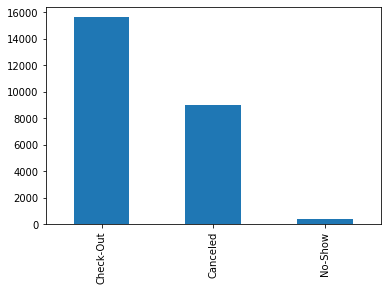

In [ ]:
import matplotlib.pyplot as plt
y_val.value_counts().sort_values(ascending=False).plot.bar();

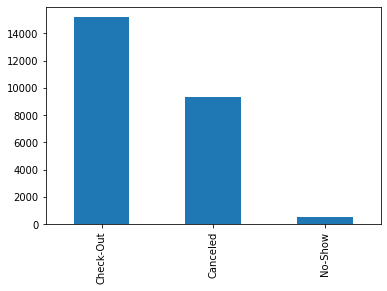

In [ ]:
pd.Series(predictions).value_counts().plot.bar();

### Confusion Matrix and recall/precision scores for the validation set

In [ ]:
cm, scores = tools.class_metrics(y_val, predictions)

In [ ]:
cm

,Check-Out,Canceled,No-Show
Check-Out,13161,2195,281
Canceled,1852,7100,81
No-Show,174,49,179


In [ ]:
scores

,precision,recall,f1-score
Check-Out,0.866596,0.841658,0.853945
Canceled,0.759846,0.786007,0.772705
No-Show,0.330869,0.445274,0.379639


As well again accuracy score.

In [ ]:
tools.accuracy_score(y_val, predictions)

0.8152520740268028

### Plotting the loss and accuracy during the model training process, seeing if indeed it had converged.

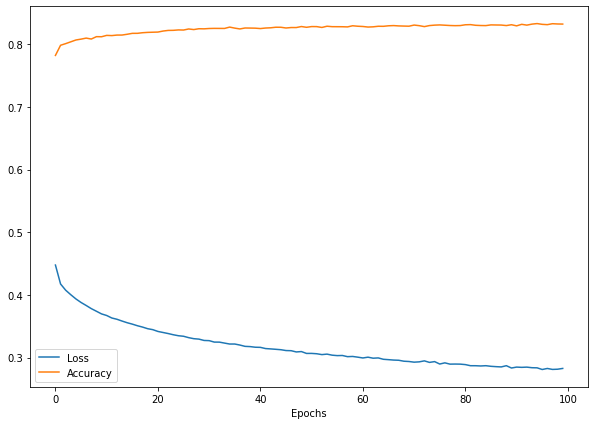

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()